In [4]:
import numpy as np
from numpy import random
from random import choices
import matplotlib.pyplot as plt
import levy
# import plotly.express as px

In [11]:
class Stimuli:
    def __init__(self,mu,dev):
        self.mu = mu
        self.dev = dev
    def sample(self):
        return random.normal(self.mu, self.dev)      # random sample from distribution of sample

def exploit(candidates,total_time):
    scores = [c.sample() for c in candidates]
    chosen = candidates[np.argmax(scores)]
    for t in range(len(candidates),total_time):
        scores.append(chosen.sample())
    return sum(scores)

def ucb1(candidates, total_time):
    scores = []                # Initialise scores
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}   # Init history then sample each option once.
    for t in range(len(candidates),total_time):
        # Find action + upper confidence bound for each candidate
        mu_plus_ucb = [np.mean(history[idx])+np.sqrt(2*np.log(t)/len(history[idx])) for idx in range(len(candidates))]
        chosen = candidates[np.argmax(mu_plus_ucb)]     # Find candidate with highest value
        score = chosen.sample()                         # Sample from candidate distribution   
        scores.append(score)                            # Add to score list
        history[candidates.index(chosen)].append(score) # Update history 
    return sum(scores)

def softmax(candidates,total_time):
    scores = []
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}        # sample each option once
    for t in range(len(candidates), total_time): 
        expected_rewards = [np.mean(history[item]) for item in history]                           # overall reward
        weights = [np.exp(np.mean(history[item])) / np.sum(np.exp(expected_rewards)) for item in history] # probability vector
        chosen = choices(candidates,weights)     # choose from candidates with ^ weights
        score = chosen[0].sample()
        scores.append(score)
        history[candidates.index(chosen[0])].append(score)
    return sum(scores)

def logistic_noise(candidates,total_time,sigma):  # Should specify the noise separately
    scores = []
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}
    for t in range(len(candidates), total_time):
        expected_rewards = [np.mean(history[item]) for item in history]
        std_rewards = [np.std(history[item]) for item in history]
        noisy_rewards = random.logistic(expected_rewards, scale = sigma)  # what scale and shape?
        chosen = candidates[np.argmax(noisy_rewards)]
        score = chosen.sample()
        scores.append(score)
        history[candidates.index(chosen)].append(score)
    return sum(scores)

def levy_noise(candidates,total_time,sig):  # Consider pregenerating noise
    scores = []
    history = {idx: [c.sample()] for idx,c in enumerate(candidates)}    # Initialise history and sample options once
    levy_noise = levy.random(alpha=1.3,beta=0,mu=0,sigma=sig,shape=(len(candidates),total_time))
    for t in range(len(candidates), total_time):
        expected_rewards = [np.mean(history[item]) for item in history]
        noisy_rewards = expected_rewards + levy_noise[:,t]
        chosen = candidates[np.argmax(noisy_rewards)]
        score = chosen.sample()
        scores.append(score)
        history[candidates.index(chosen)].append(score)
    return sum(scores)

In [6]:
# Initialising multi-armed bandit problem
num_cand = 3
var = 0.5
mu_vals = [3*i for i in range(1,num_cand)]      # consider changing setup to overlapping distributions (50/50 prob)
sig_vals = [mu*var for mu in mu_vals]
mu_sig = zip(mu_vals,sig_vals)
candidates = [Stimuli(mu,sigma) for mu,sigma in mu_sig]
total_time = 300
optimal_average = max(mu_vals)*total_time       # consider changing to sampling from max mu option
num_avg = 1000

Mean regret metric: how much value was lost compared to the optimal strategy, normalised by the score obtained by the optimal strategy. That is, lower regret is better performance.

In [7]:
exploit_vals = []
for _ in range(1000):         # Number of averages
    val = exploit(candidates,total_time)
    exploit_vals.append(val)
print('Exploit Mean Regret: %s'%((optimal_average - np.mean(exploit_vals)) / optimal_average))

Exploit Mean Regret: 0.08576672759045816


In [9]:
## Testing one algorithm
levy_vals = []
for _ in range(100):         # Number of averages
    val = levy_noise(candidates,total_time,0.3)
    levy_vals.append(val)
mean_regret = (optimal_average - np.mean(levy_vals)) / optimal_average
print('Levy Noise Mean Regret: %s'% round(mean_regret,4))


Levy Noise Mean Regret: 0.0244


In [12]:
ucb1_vals = []
for _ in range(100):
    val = ucb1(candidates,total_time)
    ucb1_vals.append(val)
print('UCB1 Mean Regret: %s'%((optimal_average - np.mean(ucb1_vals)) / optimal_average))
# print(np.mean(ucb1_vals)/total_time)

softmax_vals = []
for _ in range(100):         # Number of averages
    val = softmax(candidates,total_time)
    softmax_vals.append(val)
print('Softmax Mean Regret: %s'%((optimal_average - np.mean(softmax_vals)) / optimal_average))

logistic_vals = []
for _ in range(100):         # Number of averages
    val = logistic_noise(candidates,total_time,0.3)
    logistic_vals.append(val)
print('Logistic Noise Mean Regret: %s'%((optimal_average - np.mean(logistic_vals)) / optimal_average))


UCB1 Mean Regret: 0.02664573890106264
Softmax Mean Regret: 0.03839605795713952
Logistic Noise Mean Regret: 0.028753890189265375


In [81]:
print(np.std((optimal_average-np.array(ucb1_vals))/optimal_average),
np.std((optimal_average-np.array(levy_vals))/optimal_average),
np.std((optimal_average-np.array(softmax_vals))/optimal_average))


0.08405849011552652 0.03554234752274265 0.042881902049714184


In [120]:
# Initialising multi-armed bandit problem
mu_vals = [0.3922,0.6555,0.1712,0.7060,0.1300,0.2769,0.0462,0.0971,0.8235]
sig_vals = [0.05 for i in mu_vals]
mu_sig = zip(mu_vals,sig_vals)
candidates = [Stimuli(mu,sigma) for mu,sigma in mu_sig]
total_time = 100

bins = 1
logistic_vals = []
softmax_vals = []
opt_vals = []
for time in range(1,total_time,bins):
    logistic_vals.append(logistic_noise(candidates,time))
    softmax_vals.append(softmax(candidates,time))
    opt_vals.append(max(mu_vals)*time)

logistic_regrets = (np.array(opt_vals) - np.array(logistic_vals)) / np.array(opt_vals)
softmax_regrets = (np.array(opt_vals) - np.array(softmax_vals)) / np.array(opt_vals)


NameError: name 'bins' is not defined

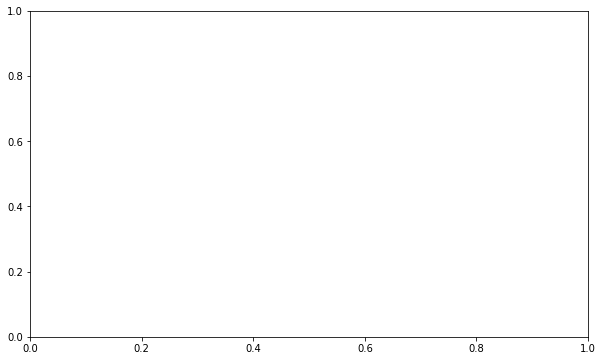

In [71]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(range(1,total_time,bins),softmax_regrets)
ax.plot(range(1,total_time,bins),logistic_regrets)
plt.show()
print(np.mean(softmax_regrets),np.mean(logistic_regrets))

array([0., 0., 0., 0., 0.])

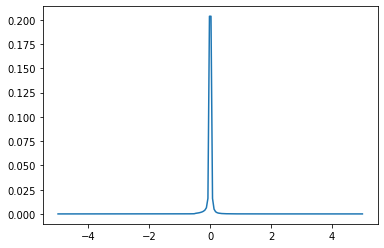

In [88]:
x = np.linspace(-5,5,200)
y = levy.levy(x,1.3,0,0,0.001,cdf = False)
plt.plot(x,y)
levy.random(alpha = 1.3, beta = 0, mu = 0, sigma = 0, shape = (5,))